PROJECT 3


In [20]:
from typing import Tuple
import importlib
import numpy as np
from numpy.linalg import inv
import numpy.random as rn
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

import proj3_gridworld
import proj3_agent
importlib.reload(proj3_gridworld)
importlib.reload(proj3_agent)
from proj3_gridworld import Gridworld
from proj3_agent import Agent

# Reinforcement Learning

Question (1)

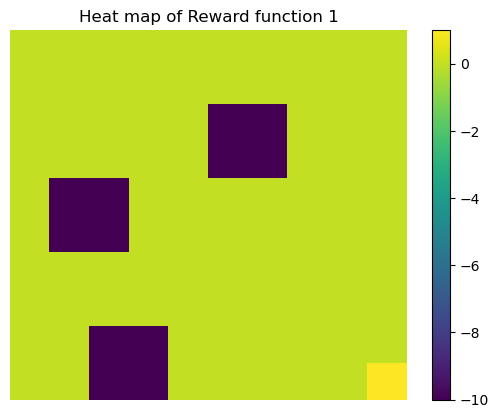

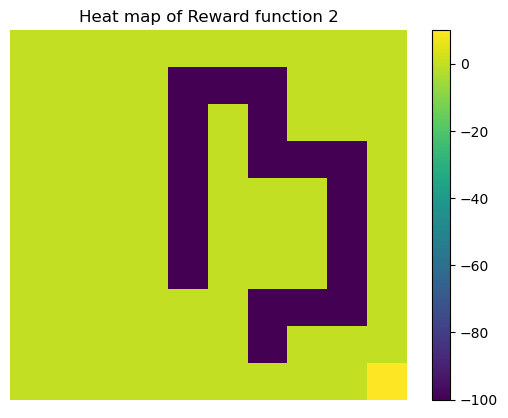

In [21]:
## For visualization generating the heat map of the ground truth reward
plt.pcolor(np.flipud(Gridworld.f1))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of Reward function 1')
plt.show()

plt.pcolor(np.flipud(Gridworld.f2))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of Reward function 2')
plt.show()

Question (2)

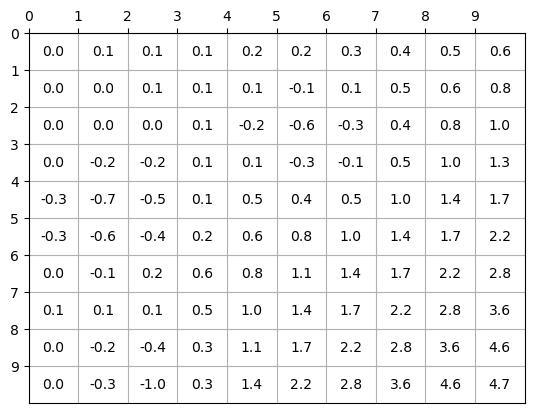

In [22]:
gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=1)
agent = Agent(gw)
agent.plot_value_matrix()

Question (3)

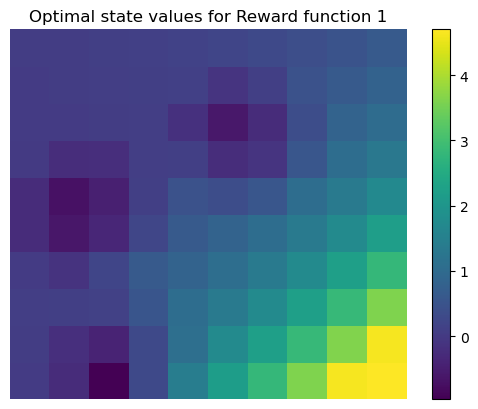

In [23]:
agent.plot_value_heatmap()

Question (4):

The values are higher for areas that are far from the penalties

Question (5):

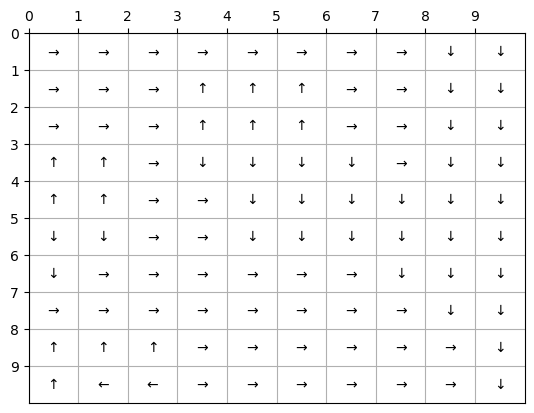

In [24]:
agent.plot_arrow()

Question(6)

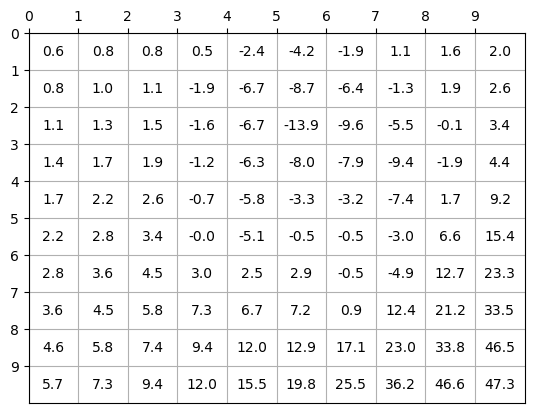

In [25]:
gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=2)
agent = Agent(gw)
agent.plot_value_matrix()

Question(7)

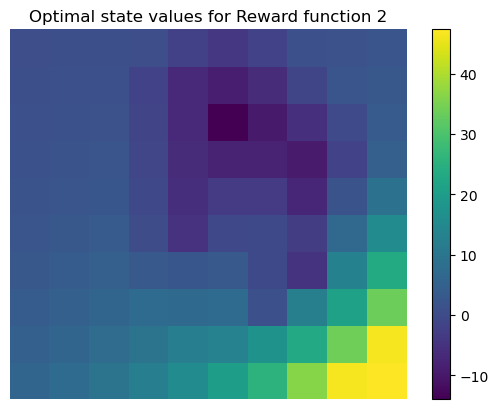

In [26]:
agent.plot_value_heatmap()

Question(8)

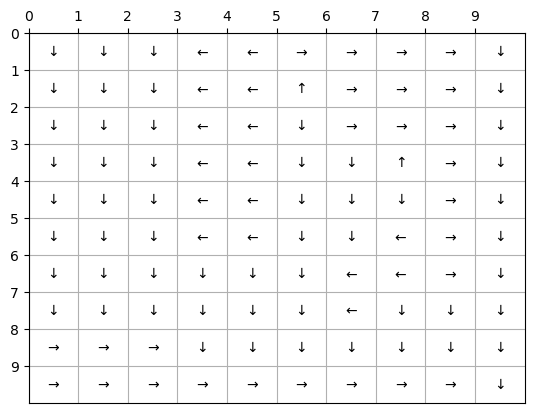

In [17]:
agent.plot_arrow()

Question(9)

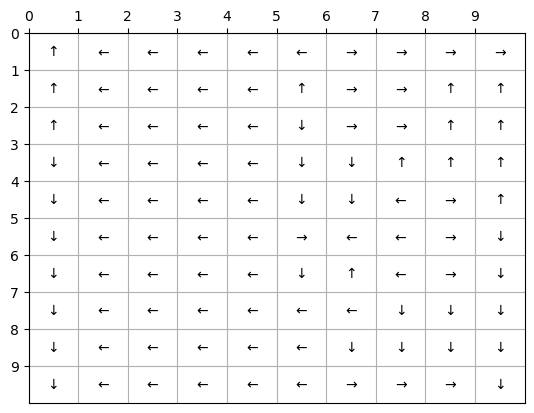

In [47]:
gw = Gridworld(grid_size=10, wind=0.6, discount=0.8, reward_function=2)
agent = Agent(gw)
agent.plot_arrow()

# Inverse Reinforcement Learning

Question(11)

In [46]:
importlib.reload(proj3_agent)
from proj3_agent import Agent

def run_plot_irl(reward_function: int, n_lambdas: int = 500, a1: int = 0) -> Tuple[float, float]:
    """Runs irl part of the project and plots lambda values vs accuracy
    
    Parameters
    ----------
    reward_function: {1, 2}
    n_lambdas: default=500
        Number of lambdas values between [0,5] to try
    a1: {0,1,2,3}, default=0

    Returns
    -------
    max_accuracy: float
        Maximum accuracy achieved
    max_lambda: float
        Lambda value that achieved the maximum accuracy          
    """
    # Setup agent and gridworld
    gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=reward_function)
    agent = Agent(gw)

    # Run IRL for each lambda
    lambdas = np.linspace(0, 5, n_lambdas)
    accuracies = np.empty(n_lambdas)
    for i, lmbd in enumerate(tqdm(lambdas)):
        accuracies[i] = agent.run_irl(lmbd)[2]

    plt.plot(lambdas, accuracies)
    plt.xlabel('Lambda')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Lambda (Reward function {reward_function})')
    plt.show()

    return np.max(accuracies), lambdas[np.argmax(accuracies)]

max_accuracy, max_lambda = run_plot_irl(reward_function=1, n_lambdas=3)

  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: The problem is infeasible

In [90]:
agent.optimal_policy

array([1, 1, 1, 2, 2, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0,
       0, 0, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

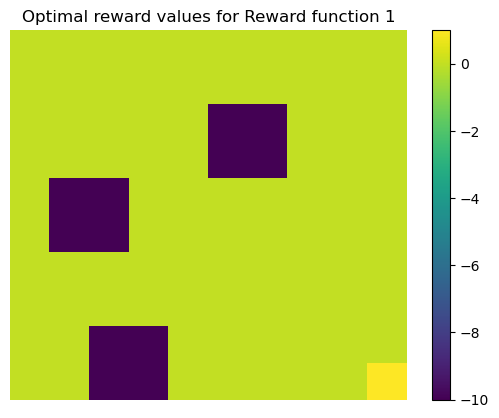

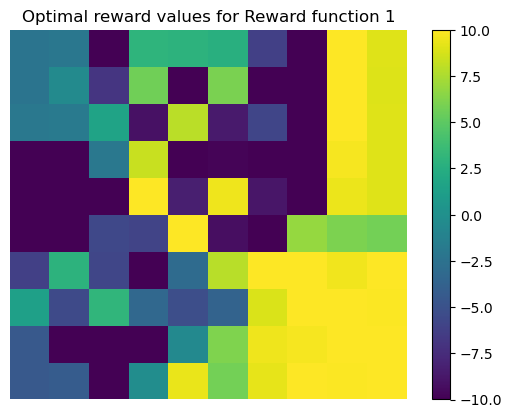

In [148]:
importlib.reload(proj3_agent)
from proj3_agent import Agent

gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=1)
agent = Agent(gw)
# agent.new_irl()
agent.run_irl(0)
agent.plot_reward_heatmap('original')
plt.show()
agent.plot_reward_heatmap('irl')

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


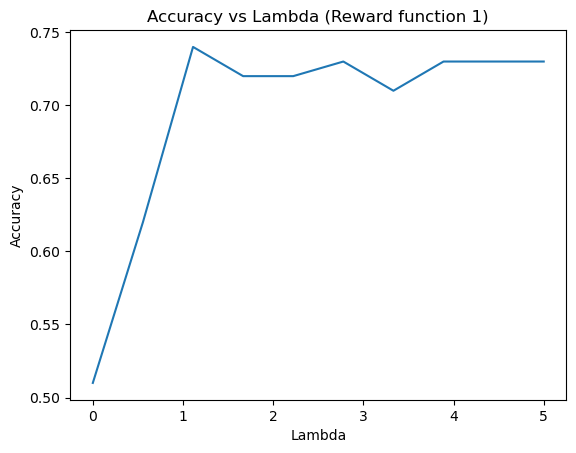

In [150]:
max_accuracy, max_lambda = run_plot_irl(reward_function=1, n_lambdas=10)

Question 12

In [21]:
print(f'Max accuracy: {max_accuracy}, lambda: {max_lambda}')

Max accuracy: 0.48, lambda: 3.9278557114228456


Question 13

[[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]]


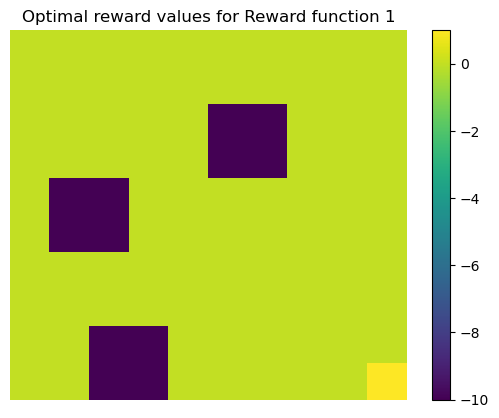

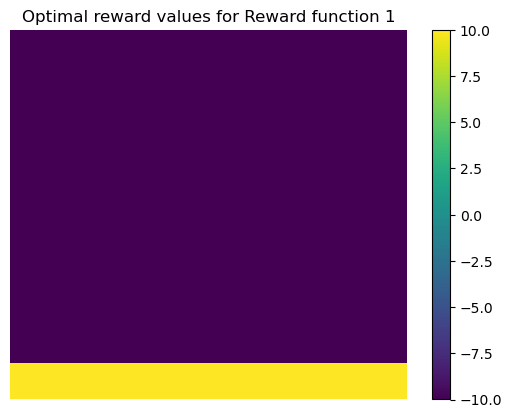

In [129]:
gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=1)
agent = Agent(gw)
agent.run_irl(max_lambda)
agent.plot_reward_heatmap('original')
plt.show()
agent.plot_reward_heatmap('irl')

Question (14)

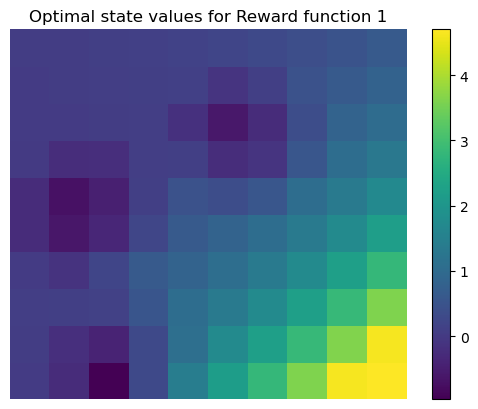

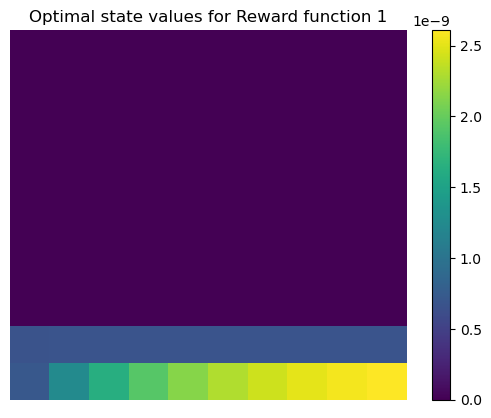

In [25]:
agent.plot_value_heatmap('original')
plt.show()
agent.plot_value_heatmap('irl')

Question (15)  
They are very different, who knows why

Question (16)

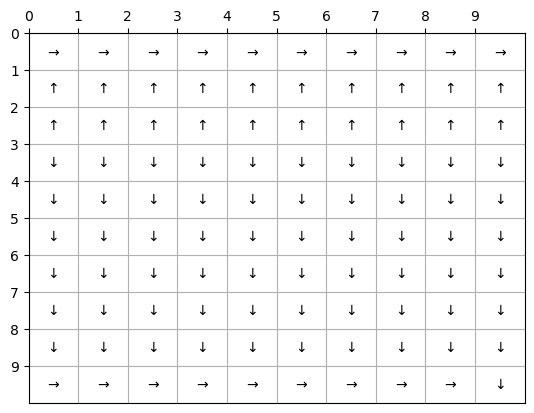

In [26]:
agent.plot_arrow('irl')

Question (17)  
They are different who knows why

Question (18)

100%|██████████| 500/500 [01:28<00:00,  5.66it/s]


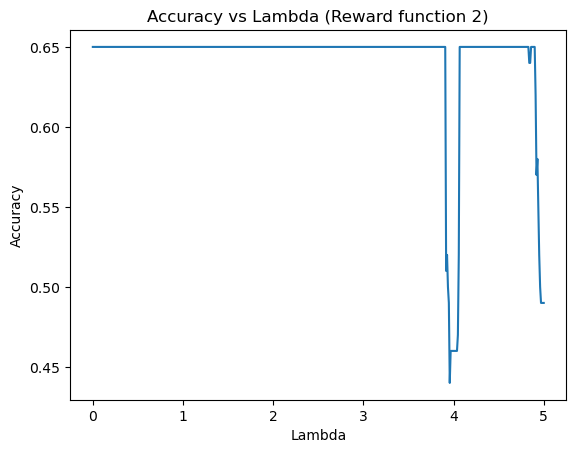

In [29]:
max_accuracy_2, max_lambda_2 = run_plot_irl(reward_function=2, n_lambdas = 500)

Question (19)

In [30]:
print(f'Max accuracy: {max_accuracy_2}, lambda: {max_lambda_2}')

Max accuracy: 0.65, lambda: 0.0


Question (20)

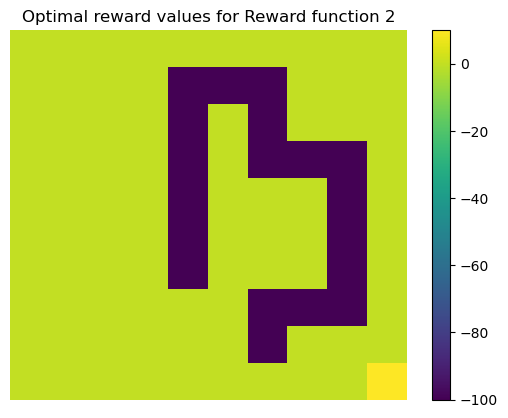

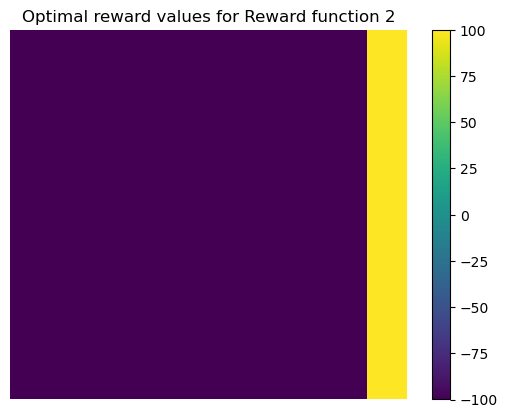

In [31]:
gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=2)
agent = Agent(gw)
agent.run_irl(max_lambda_2)
agent.plot_reward_heatmap('original')
plt.show()
agent.plot_reward_heatmap('irl')

Question (21)

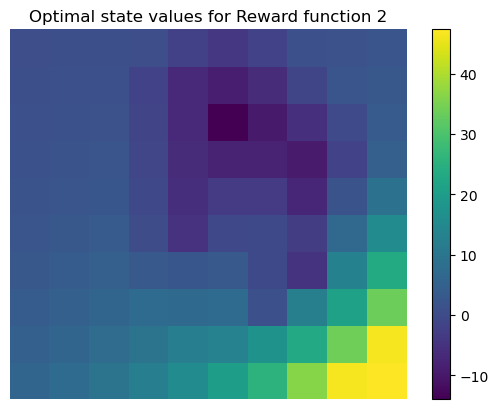

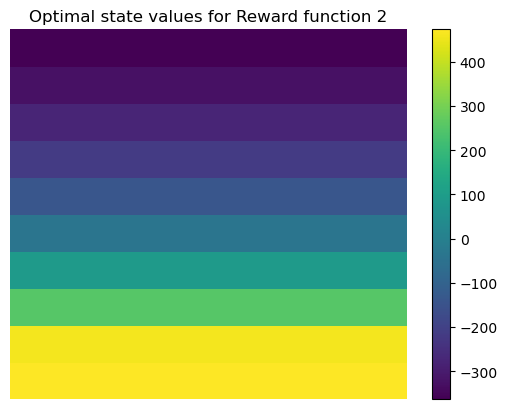

In [32]:
agent.plot_value_heatmap('original')
plt.show()
agent.plot_value_heatmap('irl')

Question (22)  
who knows

Question (23)

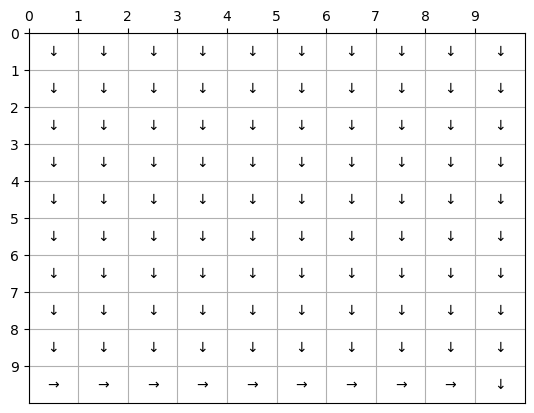

In [33]:
agent.plot_arrow('irl')

Question (24)  
who knows

Questiuon (25)